# A/B - testing Thompson sampling

In [1]:
# the code is for study Tompson stretagy of A/B testing

In [2]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from   scipy.stats import norm, bernoulli, beta

In [3]:
np.random.seed(0)

In [4]:
class bandits:
    ''' class to create bandit sample'''
    def __init__(self,prob):
        self.prob = prob
    def pull(self,j):
        reward = bernoulli.rvs(p = self.prob[j])
        return reward 

In [5]:
def experiment(eps,bandit_prob,num_step,k):
    '''produce the process of bandit selection
       input:
       - eps         - param of epsilon greedy strategy,
       - bandit_prob - list of bandits' rewards,
       - num_step    - number of repeating,
       - k : eps_t = max(eps =k*t, 0.01)
       out:
       - df with bandit number, reward for every step
       - bandits_means'''
    bandits_mean = [0,0,0]
    N_bandits = 3
    j_set      = []
    rewards    = []
    reward_sum = []
    t1 = []
    t2 = []
    t3 = []
    bandits_mean_list1 = []
    bandits_mean_list2 = []
    bandits_mean_list3 = []
    bandits_step = [0,0,0]
    reward_s = 0
    # choose bandit for first step
    S = [0,0,0]
    F = [0,0,0]
    theta = [beta.rvs(1,1,size =1),beta.rvs(1,1,size =1),beta.rvs(1,1,size =1)]
    j_max = np.argmax(theta)
    #print(theta)    
    for i in range(num_step):
        n_step = i + 1
        # do step
        reward = bandit.pull(j_max)
        # Renew S,F
        if reward == 1:
            S[j_max] = S[j_max] + 1
        else:
            F[j_max] = F[j_max] + 1
        # calculate new mean
        bandits_mean, bandits_step = new_mean(reward,j_max,bandits_mean, bandits_step)
        # Renew S,F
        # choose bandit for next step
        theta = [get_sample(S[arm],F[arm]) for arm in range(N_bandits)]
        j_max = np.argmax(theta)
        # save j and rewards
        j_set.append(j_max)
        rewards.append(reward)
        t1.append(theta[0])
        t2.append(theta[1])
        t3.append(theta[2])
        bandits_mean_list1.append(bandits_mean[0])
        bandits_mean_list2.append(bandits_mean[1])
        bandits_mean_list3.append(bandits_mean[2])
        reward_s = reward_s + reward
        reward_sum.append(reward_s)
    ind = [i+1 for i in range(num_step)]
    df = pd.DataFrame({'bandits_index': j_set,'reward':rewards,'reward_sum':reward_sum}, index = ind)
    bandits_mean_df1 = pd.DataFrame({'bandits_mean': bandits_mean_list1}, index = ind)
    bandits_mean_df2 = pd.DataFrame({'bandits_mean': bandits_mean_list2}, index = ind)
    bandits_mean_df3 = pd.DataFrame({'bandits_mean': bandits_mean_list3}, index = ind)
    bandits_means =[bandits_mean_df1,bandits_mean_df2,bandits_mean_df3]
    t1_df = pd.DataFrame({'t': t1}, index = ind)
    t2_df = pd.DataFrame({'t': t2}, index = ind)
    t3_df = pd.DataFrame({'t': t3}, index = ind)
    theta_df =[t1_df,t2_df,t3_df]
    return df , bandits_means,theta_df
def new_mean(reward,j,bandits_mean, bandits_step):
    ''' function to culculate mean rewards for bandits during process'''
    j_n_step          = bandits_step[j] + 1
    bandits_mean[j] = (j_n_step-1)/j_n_step*bandits_mean[j] + reward/j_n_step
    bandits_step[j] = j_n_step
    return bandits_mean, bandits_step
def get_sample(s,f):
    sample = beta.rvs(s+1,f+1, size =1)
    return sample

In [6]:
def out(res,bandits_means,n_from,n_to,theta_dfs):
    '''show result
    - n_from - first step to show
    - n_to   - last  step to show for 3th and 4th'''
    total_result         = res.reward.sum()
    bandit_prob_max      = np.max(bandit_prob)
    best_possible_result = num_step * bandit_prob_max
    optimal  = [i* bandit_prob_max for i in range(num_step)]
    print('epsilon = ', eps)
    print('total reward         = ',total_result)
    print('the best possible result = ',best_possible_result)
    print("efficincy : total reward/the best possible result = ",total_result/best_possible_result)
    fig,ax  = plt.subplots(2,2,figsize = (14,14))
    #ax_axis =  ax[0].twinx()
    n_show = min(n_to,res.shape[0])
    res1 = res.loc[n_from:n_show,:]
    #ax[0,0].plot(res1.index.to_numpy(), res1.reward.to_numpy() ,                  label = 'reward')
    ax[0,1].scatter(res1.index.to_numpy(), (res1.bandits_index+1).to_numpy(), ls = "--", label = "bandit's number")
    ax[0,0].set_title(f'theta for step (from {n_from} to {n_show} steps)')
    ax[0,0].set_xlabel('process step')
    ax[0,0].set_ylabel('theta')
    ax[0,1].set_ylabel("bandit's number")
    ax[0,1].set_title(f"Bandit's number (from {n_from} to {n_show} steps)")
    ax[0,0].legend(['theta',"bandit's number"] )
    ax[1,0].set_ylabel('sum of rewards')
    ax[1,0].plot(res.index.to_numpy(), res.reward_sum.to_numpy())
    ax[1,0].plot(res.index.to_numpy(), optimal)
    ax[1,0].axhline(best_possible_result, ls ="--",color = 'red')
    ax[1,0].set_title('Sum of rewards')
    ax[1,0].set_xlabel('process step')
    ax[1,0].legend(['sum of rewards','optimal way','max possible reward'] )
    for i in range(len(bandits_means)):
        dfi = bandits_means[i]
        ax[1,1].plot(dfi.index.to_numpy(), dfi.bandits_mean.to_numpy() , label = f"bandit {i+1}")
    ax[1,1].legend(['1','2','3'])
    ax[1,1].set_title("Theta")
    ax[1,1].axhline(bandit_prob[0], ls ="--",color = 'blue', label = 'prob 1')
    ax[1,1].axhline(bandit_prob[1], ls ="--",color = 'blue', label = 'prob 2')
    ax[1,1].axhline(bandit_prob[2], ls ="--",color = 'blue', label = 'prob 3')
    for i in range(len(theta_dfs)):
        dfi = theta_dfs[i]
        ax[0,0].plot(dfi.index.to_numpy(), dfi.t.to_numpy() , label = f"bandit {i+1}")
    ax[0,0].legend(['1','2','3'])
    ax[0,0].set_title("Bandits' means")
    ax[0,0].axhline(bandit_prob[0], ls ="--",color = 'blue', label = 'prob 1')
    ax[0,0].axhline(bandit_prob[1], ls ="--",color = 'blue', label = 'prob 2')
    ax[0,0].axhline(bandit_prob[2], ls ="--",color = 'blue', label = 'prob 3')
    plt.show() 

In [7]:
# create an instance of bandit
bandit_prob = [0.45, 0.5, 0.55]
bandit = bandits(bandit_prob)

In [8]:
num_step = 1000
eps = 0.8
k = 1.5/num_step

In [9]:
res, bandits_means,t_df = experiment(eps,bandit_prob,num_step,k)

epsilon =  0.8
total reward         =  511
the best possible result =  550.0
efficincy : total reward/the best possible result =  0.9290909090909091


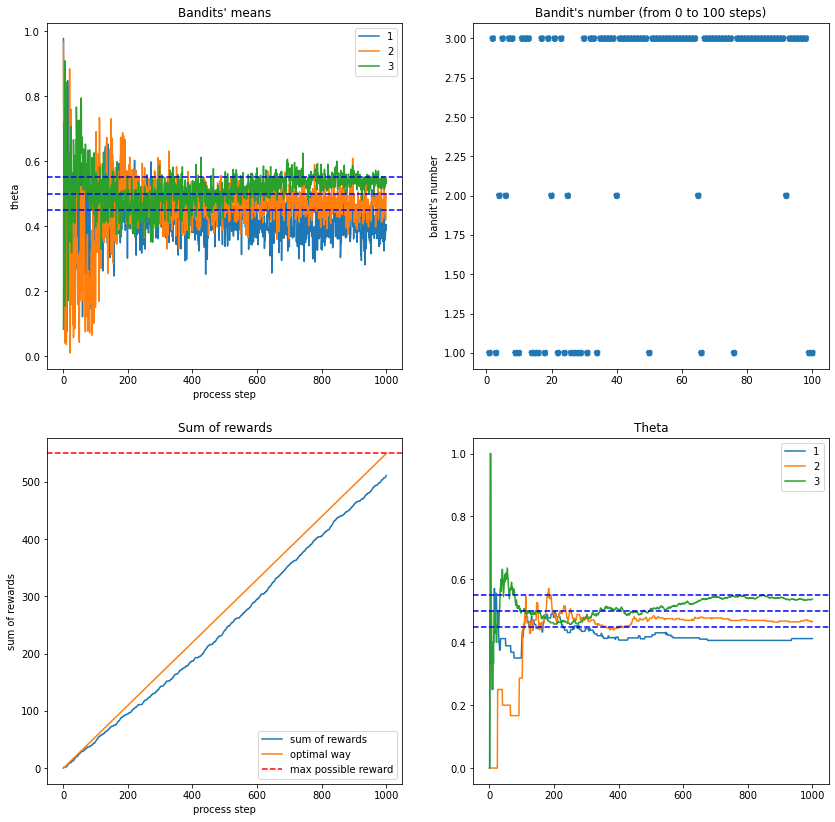

In [10]:
n_from = 0
n_to   = 100
out(res,bandits_means,n_from,n_to,t_df) 